In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('openweatherdata-denpasar-1990-2020v0.1.csv')
df.tail()

,dt_iso,timezone,city_name,lat,lon,temp,temp_min,temp_max,pressure,humidity,...,snow_3h,snow_6h,snow_12h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
264919,1/7/2020 19:00,28800,Denpasar,-8.652497,115.219117,27.0,27.0,27.0,1007.0,94,...,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
264920,1/7/2020 20:00,28800,Denpasar,-8.652497,115.219117,27.0,27.0,27.0,1007.0,94,...,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
264921,1/7/2020 21:00,28800,Denpasar,-8.652497,115.219117,28.0,28.0,28.0,1007.0,83,...,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
264922,1/7/2020 22:00,28800,Denpasar,-8.652497,115.219117,28.0,28.0,28.0,1007.0,83,...,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n
264923,1/7/2020 23:00,28800,Denpasar,-8.652497,115.219117,28.0,28.0,28.0,1008.0,83,...,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03d


In [3]:
# merubah format tanggal
df['dt_iso'] = pd.to_datetime(df['dt_iso'])

In [4]:
# Memisahkan date dengan time
df['date'] = [d.date() for d in df['dt_iso']]
df['time'] = [d.time() for d in df['dt_iso']]

In [5]:
# Membuang kolom yang tidak digunakan
df.drop(['dt_iso','timezone','city_name','lat','lon','temp_min','temp_max','pressure','humidity','wind_speed','wind_deg','rain_1h','rain_3h','rain_6h','rain_12h','rain_24h',
         'rain_today','snow_1h','snow_3h','snow_6h','snow_12h','snow_24h','snow_today','clouds_all','weather_id','weather_main','weather_description','weather_icon','time'],
        axis = 1, inplace = True)

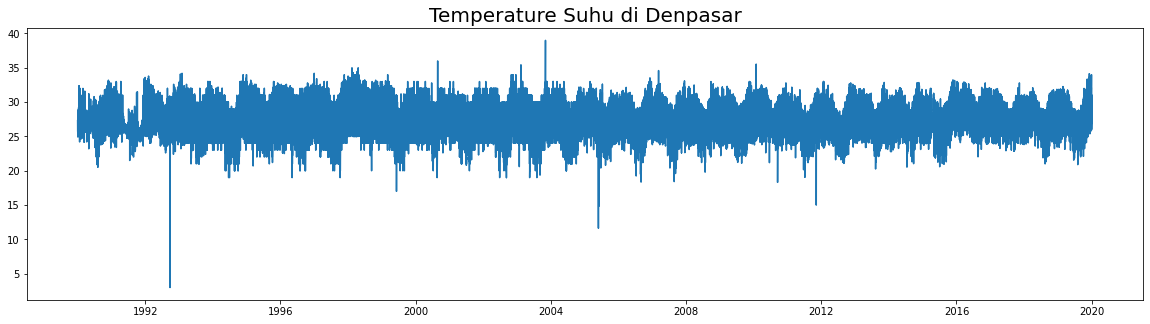

In [6]:
# Plotting dataset 'temp' and date
plt.figure(figsize=(20,5))
plt.plot(df['date'], df['temp'])
plt.title('Temperature Suhu di Denpasar', fontsize=20);

In [17]:
MAE = (df['temp'].max() - df['temp'].min()) * (10/100)
MAE

3.6

In [18]:
D = df['date'].values
T = df['temp'].values

In [19]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [20]:
from sklearn.model_selection import train_test_split

X_latih, X_uji, y_latih, y_uji = train_test_split(T, D, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(X_latih), len(X_uji))

211939 52985


In [21]:
# model
from keras.layers import Dense, LSTM

data_latih_x = windowed_dataset(X_latih, window_size=60, batch_size=100, shuffle_buffer=5000)
data_uji_x = windowed_dataset(X_uji, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 32)          192       
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          24832     
                                                                 
 lstm_5 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense_6 (Dense)             (None, None, 30)          1950      
                                                                 
 dense_7 (Dense)             (None, None, 10)          310       
                                                                 
 dense_8 (Dense)             (None, None, 1)           11        
                                                                 
 lambda_2 (Lambda)           (None, None, 1)          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [22]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < MAE):
      self.model.stop_training = True
      print("\nUdah dapet nilai MAE < 10% nih !!!")
callbacks = myCallback()

In [23]:
tf.keras.backend.set_floatx('float64')
history = model.fit(data_latih_x ,epochs=20, validation_data=data_uji_x, callbacks=[callbacks])

Epoch 1/20
2119/2119 [==============================] - 929s 436ms/step - loss: 7.5077 - mae: 7.9710 - val_loss: 2.8075 - val_mae: 3.2539
Epoch 2/20
2119/2119 [==============================] - ETA: 0s - loss: 2.3351 - mae: 2.7796
Udah dapet nilai MAE < 10% nih !!!
2119/2119 [==============================] - 861s 406ms/step - loss: 2.3351 - mae: 2.7796 - val_loss: 1.9720 - val_mae: 2.4146


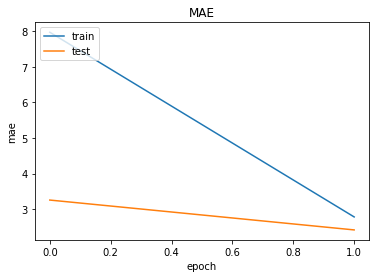

In [24]:
# membuat plot berdasarkan nilai mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

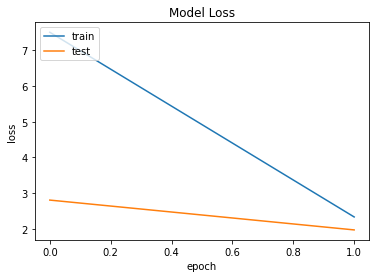

In [25]:
# plot of loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()